<a href="https://colab.research.google.com/github/wentao0420/quantumcomputer/blob/main/Quantum_Computing_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Quantum Computing Library 
---
Obtained from https://github.com/rnowotniak/qclib


In [ ]:
from numpy import *
from random import random
import copy

In [ ]:
# for floating point operations, comparisons etc.
epsilon = 10e-6

Defining quantum register class

In [ ]:
class QRegister:

    def __init__(self, m = None):
        if m == None:
            return
        if isinstance(m, ndarray) or type(m) == type([]):
            m = matrix(m)
        if isinstance(m, matrix) and m.shape[0] == 1:
            m = transpose(m)
        if not isinstance(m, matrix) or m.shape[1] != 1:
            raise WrongSizeException
        self.matrix = m
        self.size = int(math.log(m.size, 2))

    def __rmul__(self, arg1):
        # arg1 * self
        if type(arg1) not in [int, float, complex]:
            raise Exception()
        result = copy.deepcopy(self)
        result.matrix = arg1 * self.matrix
        return result

    def __add__(self, arg2):
        # self + arg2
        result = copy.deepcopy(self)
        result.matrix = self.matrix + arg2.matrix
        return result

    def __sub__(self, arg2):
        # self - arg2
        result = copy.deepcopy(self)
        result.matrix = self.matrix - arg2.matrix
        return result

    def __pow__(self, arg2):
        # self ** arg2
        result = QRegister()
        result.matrix = kron(self.matrix, arg2.matrix)
        result.size = int(math.log(result.matrix.size, 2))
        return result

    def __cmp__(self, other):
        m1 = self.matrix
        if isinstance(other, (matrix, ndarray)):
            m2 = other
        elif isinstance(other, QRegister):
            m2 = other.matrix
        else:
            return -1
        try:
            if sum(abs(m1 - m2)) < epsilon:
                return 0
            else:
                return 1
        except Exception:
            raise WrongSizeException('Comparison of different size quantum registers')

    def __str__(self):
        return str(self.matrix)

    def reset(self, n = 0):
        for i in range(self.matrix.size):
            self.matrix[i] = 0
        self.matrix[n] = 1

    def normalize(self):
        l = sqrt(sum([abs(x)**2 for x in self.matrix]))
        self.matrix = self.matrix / l
        return self

    def measure(self, *qubits):
        if len(qubits) == 0:
            # measure all qubits in register
            qubits = range(int(math.log(self.matrix.size, 2)))
        qubits = list(qubits)
        qubits.sort()
        p = {} # results probabilities
        # number of possible measurement results
        nres = 2 ** len(qubits)
        # enumerate all posible results
        for i in range(nres):
            p[dec2bin(i, int(math.log(nres, 2)))[::-1]] = 0.0
        for i in range(self.matrix.size):
            # reversed binary representation of base vector
            revbin = dec2bin(i, int(math.log(self.matrix.size, 2)))[::-1]
            # reversed binary representation of selected qubits
            revsel = ''.join([revbin[q] for q in qubits])
            p[revsel] += float(abs(self.matrix[i]) ** 2)
        keys = p.keys()
        # accumulated probabilities
        last = p[keys[0]]
        for k in keys[1:]:
            p[k] += last
            last = p[k]
        p[keys[-1]] = 1.0
        # get the measurement result according to probabilities
        r = random()
        for k in keys:
            if r <= p[k]:
                result = k
                break
        # selective reset of amplitudes
        for i in range(self.matrix.size):
            revbin = dec2bin(i, int(math.log(self.matrix.size, 2)))[::-1]
            revsel = ''.join([revbin[q] for q in qubits])
            if revsel != result:
                self.matrix[i] = 0.0
        # normalize final state
        self.normalize()
        return Ket(int(result[::-1], 2), len(qubits))

    def dirac(self, reduce = True, binary = True):
        """Return state in Dirac (bra-ket) notation"""
        elems = []
        if len(list(filter(lambda x: float(abs(x)) > 1 - epsilon, self.matrix))) == 1:
            single = True
        else:
            single = False
        for i in range(self.matrix.size):
            val = complex(real(self.matrix[i]), imag(self.matrix[i]))
            if reduce and abs(val) < epsilon:
                continue
            if abs(val) < epsilon:
                elem = '+0'
            elif imag(val) == 0:
                elem = '%+g' % abs(val)
            elif real(val) != 0:
                elem = '+%s' % str(val)
            else:
                # only imaginary part
                elem = '%+gj' % (imag(val))
            if single and reduce:
                elem = ''
            if binary:
                elem += ('|%0'+str(math.log(self.matrix.size, 2))+'d>') % int(dec2bin(i))
            else:
                elem += '|%s>' % i
            elems.append(elem)
        return ' '.join(elems)

    def outer(self, qreg):
        '''Compute an outer product with another register'''
        if self.matrix.size != transpose(qreg.matrix).size:
            raise WrongSizeException('Outer product of different size registers')
        result = Arbitrary(dot(self.matrix, transpose(qreg.matrix)))
        return result

Defining qubit class

In [ ]:
class Qubit(QRegister):

    def __init__(self, val):
        if not isinstance(val, int):
            return QRegister.__init__(self, val)
        self.size = 1
        if val == 0:
            self.matrix = transpose(matrix([[1, 0]]))
        elif val == 1:
            self.matrix = transpose(matrix([[0, 1]]))
        else:
            raise WrongSizeException

    def flip(self):
        tmp = self.matrix[0]
        self.matrix[0] = self.matrix[1]
        self.matrix[1] = tmp

Defining quantum circuit class

In [ ]:
class QCircuit:

    def __init__(self, *stages):
        self.stages = stages

    def __call__(self, qreg):
        # Efficient algorithm could be implemented here instead
        result = copy.deepcopy(qreg)
        for s in self.stages:
            result = s(result)
        return result

Defining quantum gate class

In [ ]:
class QGate:

    def __pow__(self, arg2):
        # parallel gates
        if not isinstance(arg2, QGate):
            raise Exception(repr(arg2))
        result = Stage(self, arg2)
        return result

    def __str__(self):
        return str(self.matrix)

    def __mul__(self, arg2):
        # self * arg2
        if isinstance(arg2, QRegister):
            # gate * reg
            result = QRegister()
            try:
                result.matrix = dot(self.matrix, arg2.matrix)
            except:
                raise WrongSizeException('Wrong size of input register for this gate')
            return result
        if self.matrix.shape != arg2.matrix.shape:
            raise Exception()
        # gate * gate
        result = QGate()
        # order changed!
        result.matrix = dot(arg2.matrix, self.matrix)
        return result

    def __rmul__(self, arg1):
        # arg1 * self
        if type(arg1) not in [int, float, complex]:
            raise Exception('Numerical coefficient expected')
        result = copy.deepcopy(self)
        result.matrix = arg1 * self.matrix
        return result

    def __add__(self, arg2):
        # self + arg2
        result = copy.deepcopy(self)
        result.matrix = self.matrix + arg2.matrix
        return result

    def __sub__(self, arg2):
        # self - arg2
        result = copy.deepcopy(self)
        result.matrix = self.matrix - arg2.matrix
        return result

    def __call__(self, qreg):
        return self.compute(qreg)

    def compute(self, qreg):
        if not isinstance(qreg, QRegister):
            raise Exception()
        return self * qreg

    def trace(self):
        return self.matrix.trace()

    def determinant(self):
        return linalg.det(self.matrix)

    def transpose(self):
        self.matrix = transpose(self.matrix)
        return self

    def inverse(self):
        self.matrix = linalg.inv(self.matrix)
        return self

Defining quantum computing stage (a layer in circuit)

In [ ]:
class Stage(QGate):

    def __init__(self, *gates):
        self.gates = gates
        m = self.gates[0].matrix
        for g in self.gates[1:]:
            m = kron(m, g.matrix)
        self.matrix = m
        self.size = sum([g.size for g in gates])

Defining elementary quantum gates

In [ ]:
class ElementaryQuantumGate(QGate):
    pass


class Identity(ElementaryQuantumGate):
    def __init__(self, size = 1):
        self.matrix = eye(2 ** size)
        self.size = size
        

class Hadamard(ElementaryQuantumGate):
    def __init__(self, size = 1):
        h = s2 * matrix([
            [1, 1],
            [1, -1]])
        m = h
        for i in range(size - 1):
            m = kron(m, h)
        self.matrix = m
        self.size = size


class CNot(ElementaryQuantumGate):
    '''Controlled not gate'''

    def __init__(self, control = 1, target = 0):
        if control == target:
            # (it would impose non-unitary matrix)
            raise Exception('Control and target qubits cannot be equal')
        elif control == 1 and target == 0:
            self.matrix = matrix([
                [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 1, 0]])
            self.size = 2
        elif control == 0 and target == 1:
            self.matrix = matrix([
                [1, 0, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 1, 0],
                [0, 1, 0, 0]])
            self.size = 2
        else:
            size = max(control, target) + 1
            if size == 1:
                size = 2
            dim = 2 ** size
            self.matrix = eye(dim)
            # find correct permutation of identity matrix columns
            for b in range(dim):
                bstr = dec2bin(b, size)
                if bstr[-(control+1)] == '1':
                    bstr = list(bstr)
                    if bstr[-(target+1)] == '0':
                        bstr[-(target+1)] = '1'
                    else:
                        bstr[-(target+1)] = '0'
                    bstr = ''.join(bstr)
                    self.matrix[:,b] = eye(dim)[:,int(bstr, 2)]
            self.size = size


class Not(ElementaryQuantumGate):
    '''Not gate'''

    def __init__(self):
        self.matrix = matrix([
            [0, 1],
            [1, 0]])
        self.size = 1


class PhaseShift(ElementaryQuantumGate):
    def __init__(self, angle = pi):
        self.angle = angle
        self.matrix = matrix([
            [1, 0],
            [0, exp(angle * 1j)]])
        self.size = 1


class Toffoli(ElementaryQuantumGate):
    '''Toffoli gate -- Controlled Controlled Not gate'''
    def __init__(self):
        self.matrix = matrix([
            [ 1,  0,  0,  0,  0,  0,  0,  0],
            [ 0,  1,  0,  0,  0,  0,  0,  0],
            [ 0,  0,  1,  0,  0,  0,  0,  0],
            [ 0,  0,  0,  1,  0,  0,  0,  0],
            [ 0,  0,  0,  0,  1,  0,  0,  0],
            [ 0,  0,  0,  0,  0,  1,  0,  0],
            [ 0,  0,  0,  0,  0,  0,  0,  1],
            [ 0,  0,  0,  0,  0,  0,  1,  0]])
        self.size = 3


class Fredkin(ElementaryQuantumGate):
    '''Fredkin gate -- Controlled Swap gate'''
    def __init__(self):
        self.matrix = matrix([
            [ 1,  0,  0,  0,  0,  0,  0,  0],
            [ 0,  1,  0,  0,  0,  0,  0,  0],
            [ 0,  0,  1,  0,  0,  0,  0,  0],
            [ 0,  0,  0,  1,  0,  0,  0,  0],
            [ 0,  0,  0,  0,  1,  0,  0,  0],
            [ 0,  0,  0,  0,  0,  0,  1,  0],
            [ 0,  0,  0,  0,  0,  1,  0,  0],
            [ 0,  0,  0,  0,  0,  0,  0,  1]])
        self.size = 3


class Swap(ElementaryQuantumGate):
    '''Qubits order swap gate'''
    def __init__(self):
        self.matrix = matrix([
            [1, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1]])
        self.size = 2


class Arbitrary(ElementaryQuantumGate):
    '''Quantum gate with arbitrary unitary matrix'''
    def __init__(self, m):
        m = matrix(m)
        if (m.H * m == eye(m.shape[0])).any() == False:
            pass
            # raise Exception, 'Not unitary matrix for quantum gate'
        self.matrix = m
        self.size = int(math.log(m.shape[0], 2))

In [ ]:
class WrongSizeException(Exception):
    def __str__(self):
        return 'Wrong size of quantum computing object'


def dec2bin(dec, length = None):
    """convert decimal value to binary string"""
    result = ''
    if dec < 0:
        raise ValueError("Must be a positive integer")
    if dec == 0:
        result = '0'
        if length != None:
            result = result.rjust(length, '0')
        return result
    while dec > 0:
        result = str(dec % 2) + result
        dec = dec >> 1
    if length != None:
        result = result.rjust(length, '0')
    return result


def Ket(n, size = None):
    if (n == 0 or n == 1) and size == None:
        return Qubit(n)
    ket = QRegister()
    if size == None:
        size = int(floor(math.log(n, 2)) + 1)
    ket.matrix = transpose(matrix([zeros(2 ** size)]))
    ket.matrix[n] = 1
    return ket


def epr(qreg = Ket(0) ** Ket(0)):
    """Generate an EPR-pair for |00> input state"""
    circ = (Hadamard() ** I) * CNot()
    return circ(qreg)

Assigning operations

In [ ]:
ket0 = Ket(0)
ket1 = Ket(1)
s2 = sqrt(2) / 2

h = Hadamard()
I = Identity()
cnot = CNot()
cnot2 = CNot(0, 1)
T = Arbitrary(matrix([
    [1, 0],
    [0, exp(1.0j*pi/4)]]))

Testing

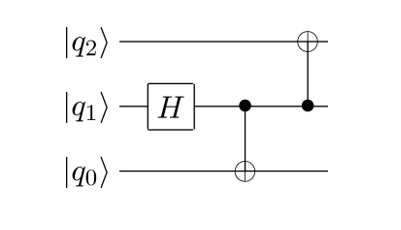

In [ ]:
circuit = (I ** Hadamard() ** I) * (I ** CNot()) * (CNot(0, 1) ** I)
result = circuit(ket0 ** ket0 ** ket0)

In [ ]:
result

In [ ]:
result.dirac()

'+0.707107|000> +0.707107|111>'